# Model Selection & Evaluation

## Table of Contents

(1) Data Loading and Preparation

(2) Feature Engineering for Modeling

(3) Model Architecture Setup

(4) Cross-Validation Strategy

(5) Baseline Model Development

(6) Advanced Model Testing

(7) Model Comparison and Selection

(8) Final Model Evaluation

<hr>

(1) Data Loading and Preparation

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

# Machine Learning Libraries
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso,
    ElasticNet,
    ElasticNetCV,
)
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor,
)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Advanced ML Libraries
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Statistical Analysis
from scipy import stats
from scipy.stats import skew
from scipy.special import boxcox1p

# Set plotting style
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")

print("All libraries imported successfully! 📚")

All libraries imported successfully! 📚


In [2]:
# Load the processed data from EDA
try:
    train_data = pd.read_csv("processed_train.csv")
    test_data = pd.read_csv("processed_test.csv")
    print(f"✅ Training data loaded: {train_data.shape}")
    print(f"✅ Test data loaded: {test_data.shape}")
except FileNotFoundError:
    print("❌ Processed files not found. Please run the EDA notebook first.")
    print("Expected files: processed_train.csv, processed_test.csv")

✅ Training data loaded: (1460, 85)
✅ Test data loaded: (1459, 85)


In [3]:
# Quick data overview
print("Training Data Summary:")
print(f"Shape: {train_data.shape}")
print(f"Missing values: {train_data.isnull().sum().sum()}")
print(
    f"Target variable (SalePrice) range: ${train_data['SalePrice'].min():,.0f} - ${train_data['SalePrice'].max():,.0f}"
)

# Check data types
print(f"\nData types distribution:")
print(train_data.dtypes.value_counts())

Training Data Summary:
Shape: (1460, 85)
Missing values: 3241
Target variable (SalePrice) range: $34,900 - $755,000

Data types distribution:
int64      44
object     24
float64    17
Name: count, dtype: int64


<hr>

(2) Feature Engineering for Modeling

(2.1) Target Variable Analysis and Transformation

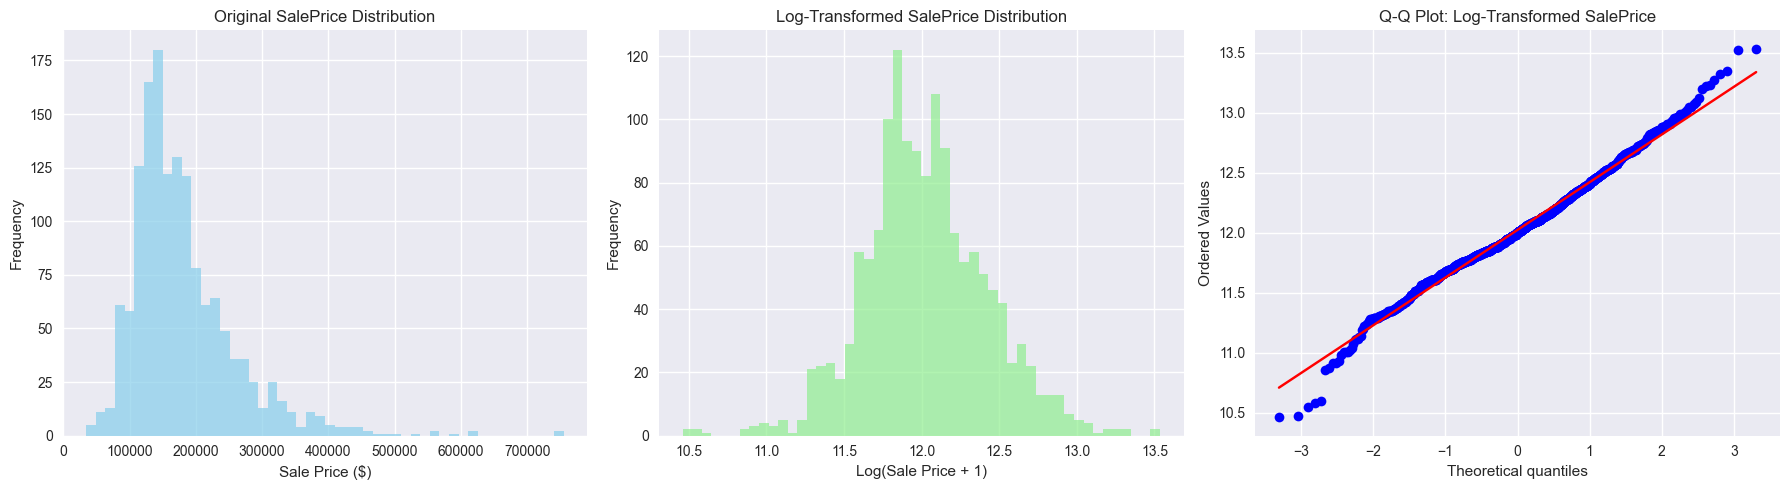

Original SalePrice skewness: 1.881
Log-transformed skewness: 0.121
Improvement in skewness: 1.760


In [4]:
# Analyze target variable distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Original distribution
axes[0].hist(train_data["SalePrice"], bins=50, alpha=0.7, color="skyblue")
axes[0].set_title("Original SalePrice Distribution")
axes[0].set_xlabel("Sale Price ($)")
axes[0].set_ylabel("Frequency")

# Log transformation
log_prices = np.log1p(train_data["SalePrice"])
axes[1].hist(log_prices, bins=50, alpha=0.7, color="lightgreen")
axes[1].set_title("Log-Transformed SalePrice Distribution")
axes[1].set_xlabel("Log(Sale Price + 1)")
axes[1].set_ylabel("Frequency")

# Q-Q plot for normality check
stats.probplot(log_prices, dist="norm", plot=axes[2])
axes[2].set_title("Q-Q Plot: Log-Transformed SalePrice")

plt.tight_layout()
plt.show()

# Calculate skewness
original_skew = skew(train_data["SalePrice"])
log_skew = skew(log_prices)

print(f"Original SalePrice skewness: {original_skew:.3f}")
print(f"Log-transformed skewness: {log_skew:.3f}")
print(f"Improvement in skewness: {abs(original_skew) - abs(log_skew):.3f}")

(2.2) Complete Feature Preprocessing Pipeline

In [5]:
# Separate features and target
X = train_data.drop(["Id", "SalePrice"], axis=1)
y = np.log1p(train_data["SalePrice"])  # Log transform target
X_test = test_data.drop(["Id"], axis=1)

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Test features shape: {X_test.shape}")

Features shape: (1460, 83)
Target shape: (1460,)
Test features shape: (1459, 84)


In [6]:
# Step 1: Handle missing values
print(f"\n🔧 Step 1: Handle missing values")
print(f"Missing values in training: {X.isnull().sum().sum()}")
print(f"Missing values in test: {X_test.isnull().sum().sum()}")


def impute_missing_values(df_train, df_test):
    """Handle missing values with domain knowledge"""

    # Make copies to avoid modifying originals
    df_train = df_train.copy()
    df_test = df_test.copy()

    # Specific imputation strategies
    if "LotFrontage" in df_train.columns:
        median_frontage = df_train["LotFrontage"].median()
        df_train["LotFrontage"].fillna(median_frontage, inplace=True)
        df_test["LotFrontage"].fillna(median_frontage, inplace=True)
        print(f"  ✅ LotFrontage: filled with median ({median_frontage:.1f})")

    if "MasVnrArea" in df_train.columns:
        df_train["MasVnrArea"].fillna(0, inplace=True)
        df_test["MasVnrArea"].fillna(0, inplace=True)
        print(f"  ✅ MasVnrArea: filled with 0")

    if "GarageYrBlt" in df_train.columns:
        df_train["GarageYrBlt"].fillna(df_train["YearBuilt"], inplace=True)
        df_test["GarageYrBlt"].fillna(df_test["YearBuilt"], inplace=True)
        print(f"  ✅ GarageYrBlt: filled with YearBuilt")

    # Handle remaining missing values
    numeric_features = df_train.select_dtypes(include=[np.number]).columns
    for feature in numeric_features:
        if df_train[feature].isnull().any():
            median_val = df_train[feature].median()
            df_train[feature].fillna(median_val, inplace=True)
            df_test[feature].fillna(median_val, inplace=True)
            print(f"  ✅ {feature}: filled with median")

    categorical_features = df_train.select_dtypes(include=["object"]).columns
    for feature in categorical_features:
        if df_train[feature].isnull().any():
            mode_val = df_train[feature].mode()
            fill_val = mode_val[0] if len(mode_val) > 0 else "Unknown"
            df_train[feature].fillna(fill_val, inplace=True)
            df_test[feature].fillna(fill_val, inplace=True)
            print(f"  ✅ {feature}: filled with mode/Unknown")

    return df_train, df_test


# Apply missing value imputation
X, X_test = impute_missing_values(X, X_test)

print(f"After imputation - Training missing: {X.isnull().sum().sum()}")
print(f"After imputation - Test missing: {X_test.isnull().sum().sum()}")


🔧 Step 1: Handle missing values
Missing values in training: 3241
Missing values in test: 4675
  ✅ LotFrontage: filled with median (69.0)
  ✅ MasVnrArea: filled with 0
  ✅ GarageYrBlt: filled with YearBuilt
  ✅ BsmtQual: filled with median
  ✅ Alley: filled with mode/Unknown
  ✅ GarageType: filled with mode/Unknown
  ✅ MiscFeature: filled with mode/Unknown
After imputation - Training missing: 0
After imputation - Test missing: 1475


In [7]:
# Step 2: Identify feature types and handle skewness
print(f"\n🔧 Step 2: Handle skewed numerical features")
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

print(f"Numerical features: {len(numeric_features)}")
print(f"Categorical features: {len(categorical_features)}")

# Find skewed features
skewed_features = []
skewness_threshold = 0.5

for feature in numeric_features:
    if X[feature].nunique() > 2:  # Skip binary features
        feature_skewness = skew(X[feature])
        if abs(feature_skewness) > skewness_threshold:
            skewed_features.append(feature)

print(f"Found {len(skewed_features)} skewed features")

# Apply Box-Cox transformation
X_processed = X.copy()
X_test_processed = X_test.copy()

for feature in skewed_features:
    if (X_processed[feature] >= 0).all():  # Box-Cox requires non-negative values
        X_processed[feature] = boxcox1p(X_processed[feature], 0.15)
        X_test_processed[feature] = boxcox1p(X_test_processed[feature], 0.15)

print(f"Applied Box-Cox transformation to {len(skewed_features)} features")


🔧 Step 2: Handle skewed numerical features
Numerical features: 59
Categorical features: 24
Found 46 skewed features
Applied Box-Cox transformation to 46 features


In [8]:
# Step 3: One-hot encode categorical features
print(f"\n🔧 Step 3: One-hot encode categorical features")
if len(categorical_features) > 0:
    X_processed = pd.get_dummies(
        X_processed, columns=categorical_features, drop_first=True
    )
    X_test_processed = pd.get_dummies(
        X_test_processed, columns=categorical_features, drop_first=True
    )

    # Align test data with training data
    missing_cols = set(X_processed.columns) - set(X_test_processed.columns)
    for col in missing_cols:
        X_test_processed[col] = 0

    extra_cols = set(X_test_processed.columns) - set(X_processed.columns)
    X_test_processed = X_test_processed.drop(extra_cols, axis=1)

    X_test_processed = X_test_processed[X_processed.columns]

print(f"After encoding - Training shape: {X_processed.shape}")
print(f"After encoding - Test shape: {X_test_processed.shape}")


🔧 Step 3: One-hot encode categorical features
After encoding - Training shape: (1460, 204)
After encoding - Test shape: (1459, 204)


In [9]:
# Step 4: Final preprocessing and scaling
print(f"\n🔧 Step 4: Final preprocessing and scaling")

# Handle any remaining missing values
final_missing_train = X_processed.isnull().sum().sum()
final_missing_test = X_test_processed.isnull().sum().sum()

if final_missing_train > 0 or final_missing_test > 0:
    print("⚠️ Applying final missing value fix...")
    X_processed = X_processed.fillna(0)
    X_test_processed = X_test_processed.fillna(0)
    print("✅ All missing values filled with 0")

# Scale features
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_processed)
X_test_scaled = scaler.transform(X_test_processed)

# Final verification
print(f"\n✅ PREPROCESSING COMPLETE")
print(f"Training data: {X_scaled.shape} - NaN count: {np.isnan(X_scaled).sum()}")
print(f"Test data: {X_test_scaled.shape} - NaN count: {np.isnan(X_test_scaled).sum()}")

if np.isnan(X_scaled).sum() == 0 and np.isnan(X_test_scaled).sum() == 0:
    print("🎉 SUCCESS: No NaN values detected - ready for modeling!")
else:
    print("❌ ERROR: Still have NaN values")


🔧 Step 4: Final preprocessing and scaling
⚠️ Applying final missing value fix...
✅ All missing values filled with 0

✅ PREPROCESSING COMPLETE
Training data: (1460, 204) - NaN count: 0
Test data: (1459, 204) - NaN count: 0
🎉 SUCCESS: No NaN values detected - ready for modeling!


<hr>

(3) Model Architecture Setup

In [10]:
# Define evaluation metrics
def evaluate_model(y_true, y_pred):
    """Calculate comprehensive evaluation metrics"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return {"RMSE": rmse, "MAE": mae, "R²": r2}


def rmse_cv(model, X, y, cv=5):
    """Cross-validation RMSE score"""
    scores = cross_val_score(model, X, y, cv=cv, scoring="neg_mean_squared_error")
    return np.sqrt(-scores)

In [11]:
# Initialize models for comparison
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.001),
    "ElasticNet": ElasticNetCV(
        alphas=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
        l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9],
        cv=5,
        random_state=42,
    ),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=100, random_state=42, verbose=-1),
}

print("Model zoo initialized with 8 algorithms:")
for name in models.keys():
    print(f"  - {name}")

Model zoo initialized with 8 algorithms:
  - Linear Regression
  - Ridge Regression
  - Lasso Regression
  - ElasticNet
  - Random Forest
  - Gradient Boosting
  - XGBoost
  - LightGBM


<hr>

(4) Cross-Validation Strategy

In [12]:
# Set up cross-validation
n_folds = 5
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)

print(f"✅ {n_folds}-Fold cross-validation strategy set up")
print(
    f"✅ Features ready: Scaled ({X_scaled.shape}) and Processed ({X_processed.shape})"
)

✅ 5-Fold cross-validation strategy set up
✅ Features ready: Scaled ((1460, 204)) and Processed ((1460, 204))


<hr>

(5) Baseline Model Development

In [13]:
# Test baseline linear regression first
print("Testing baseline Linear Regression model...")

# Create train/validation split for initial testing
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Fit baseline model
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

# Predictions
y_train_pred = baseline_model.predict(X_train)
y_val_pred = baseline_model.predict(X_val)

# Evaluate
train_metrics = evaluate_model(y_train, y_train_pred)
val_metrics = evaluate_model(y_val, y_val_pred)

print("\nBaseline Linear Regression Results:")
print(f"Training RMSE: {train_metrics['RMSE']:.4f}")
print(f"Validation RMSE: {val_metrics['RMSE']:.4f}")
print(f"Training R²: {train_metrics['R²']:.4f}")
print(f"Validation R²: {val_metrics['R²']:.4f}")

Testing baseline Linear Regression model...

Baseline Linear Regression Results:
Training RMSE: 0.0933
Validation RMSE: 0.1678
Training R²: 0.9429
Validation R²: 0.8492


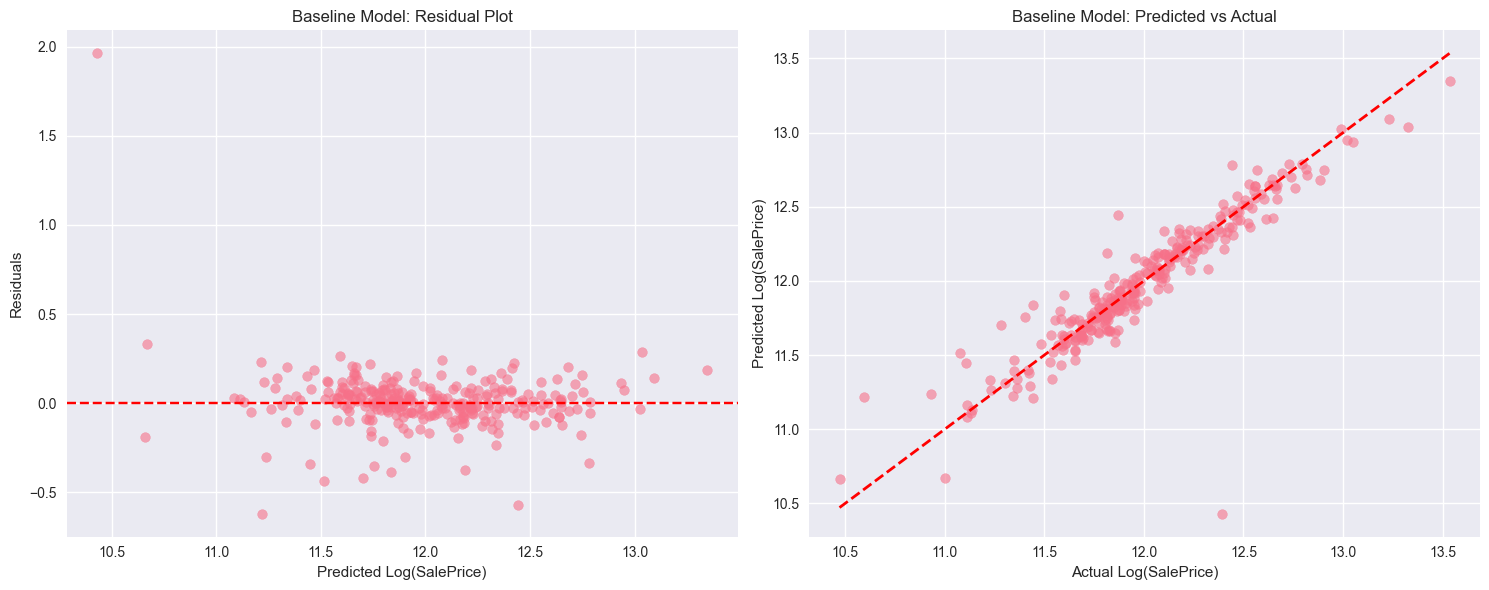

In [14]:
# Visualize baseline model performance
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Residual plot
residuals = y_val - y_val_pred
axes[0].scatter(y_val_pred, residuals, alpha=0.6)
axes[0].axhline(y=0, color="r", linestyle="--")
axes[0].set_xlabel("Predicted Log(SalePrice)")
axes[0].set_ylabel("Residuals")
axes[0].set_title("Baseline Model: Residual Plot")

# Prediction vs Actual
axes[1].scatter(y_val, y_val_pred, alpha=0.6)
axes[1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], "r--", lw=2)
axes[1].set_xlabel("Actual Log(SalePrice)")
axes[1].set_ylabel("Predicted Log(SalePrice)")
axes[1].set_title("Baseline Model: Predicted vs Actual")

plt.tight_layout()
plt.show()

<hr>

(6) Advanced Model Testing

In [15]:
# Cross-validation comparison of all models
print("Performing cross-validation on all models...")
print("=" * 60)

cv_results = {}

for name, model in models.items():
    print(f"\nTesting {name}...")

    try:
        # Use scaled features for linear models, original for tree-based
        if name in [
            "Linear Regression",
            "Ridge Regression",
            "Lasso Regression",
            "ElasticNet",
        ]:
            scores = rmse_cv(model, X_scaled, y, cv=n_folds)
        else:
            scores = rmse_cv(model, X_processed, y, cv=n_folds)

        cv_results[name] = {
            "scores": scores,
            "mean": scores.mean(),
            "std": scores.std(),
        }

        print(f"  RMSE: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

    except Exception as e:
        print(f"  ❌ Error: {e}")
        cv_results[name] = {"scores": None, "mean": np.inf, "std": 0}

print("\n" + "=" * 60)
print("Cross-validation completed!")

Performing cross-validation on all models...

Testing Linear Regression...
  RMSE: 0.1559 (+/- 0.0604)

Testing Ridge Regression...
  RMSE: 0.1316 (+/- 0.0287)

Testing Lasso Regression...
  RMSE: 0.1259 (+/- 0.0311)

Testing ElasticNet...
  RMSE: 0.1256 (+/- 0.0312)

Testing Random Forest...
  RMSE: 0.1444 (+/- 0.0156)

Testing Gradient Boosting...
  RMSE: 0.1276 (+/- 0.0168)

Testing XGBoost...
  RMSE: 0.1429 (+/- 0.0162)

Testing LightGBM...
  RMSE: 0.1301 (+/- 0.0174)

Cross-validation completed!


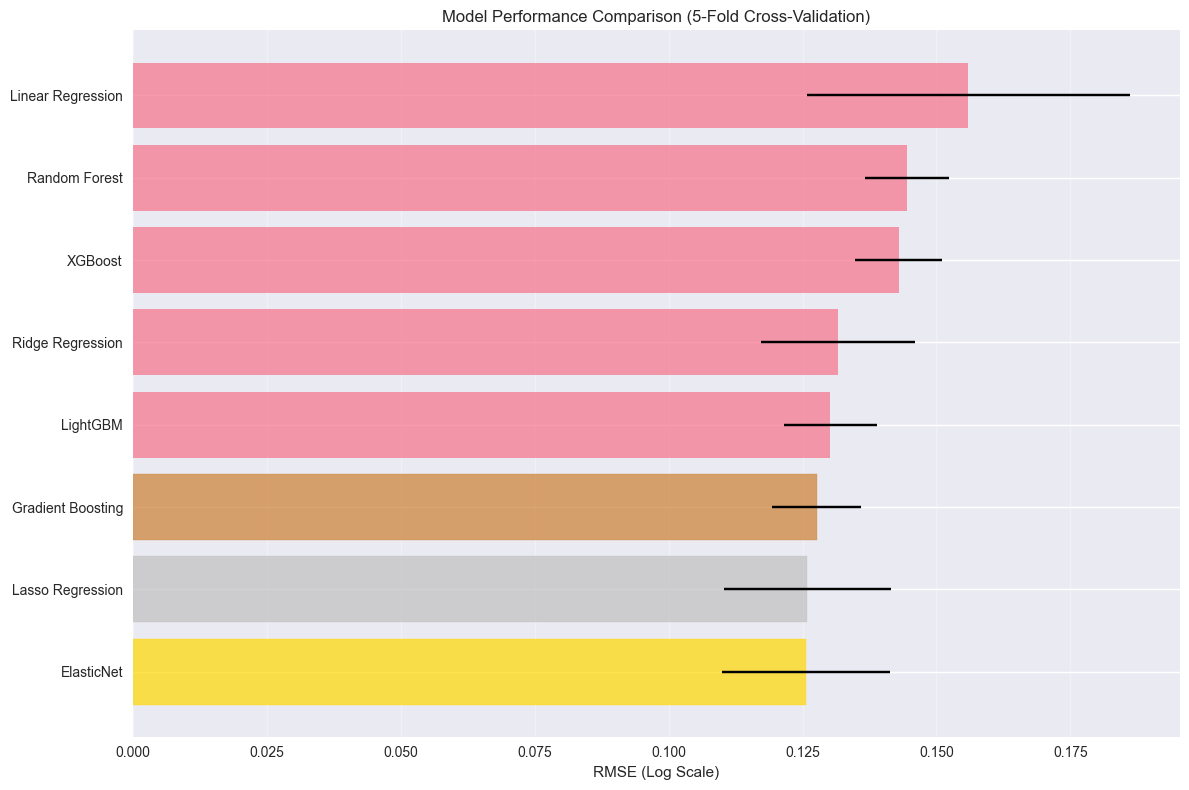


🏆 Model Performance Ranking:
🥇 ElasticNet: 0.1256 (+/- 0.0156)
🥈 Lasso Regression: 0.1259 (+/- 0.0156)
🥉 Gradient Boosting: 0.1276 (+/- 0.0084)
4. LightGBM: 0.1301 (+/- 0.0087)
5. Ridge Regression: 0.1316 (+/- 0.0143)
6. XGBoost: 0.1429 (+/- 0.0081)
7. Random Forest: 0.1444 (+/- 0.0078)
8. Linear Regression: 0.1559 (+/- 0.0302)


In [16]:
# Create comparison visualization
model_names = []
mean_scores = []
std_scores = []

for name, results in cv_results.items():
    if results["scores"] is not None:
        model_names.append(name)
        mean_scores.append(results["mean"])
        std_scores.append(results["std"])

# Sort by performance
sorted_indices = np.argsort(mean_scores)
model_names = [model_names[i] for i in sorted_indices]
mean_scores = [mean_scores[i] for i in sorted_indices]
std_scores = [std_scores[i] for i in sorted_indices]

# Create bar plot
plt.figure(figsize=(12, 8))
y_pos = np.arange(len(model_names))

bars = plt.barh(y_pos, mean_scores, xerr=std_scores, alpha=0.7, capsize=5)
plt.yticks(y_pos, model_names)
plt.xlabel("RMSE (Log Scale)")
plt.title("Model Performance Comparison (5-Fold Cross-Validation)")
plt.grid(axis="x", alpha=0.3)

# Color best performing models
bars[0].set_color("gold")
bars[1].set_color("silver")
bars[2].set_color("#CD7F32")  # Bronze

plt.tight_layout()
plt.show()

# Print ranking
print("\n🏆 Model Performance Ranking:")
for i, (name, score, std) in enumerate(zip(model_names, mean_scores, std_scores)):
    medal = "🥇" if i == 0 else "🥈" if i == 1 else "🥉" if i == 2 else f"{i+1}."
    print(f"{medal} {name}: {score:.4f} (+/- {std:.4f})")

<hr>

(7) Model Comparison and Selection

In [17]:
# Detailed analysis of top 3 models
top_3_models = model_names[:3]
print(f"Detailed analysis of top 3 models: {', '.join(top_3_models)}")

detailed_results = {}

for model_name in top_3_models:
    print(f"\n📊 Analyzing {model_name}...")

    model = models[model_name]

    # Use appropriate feature set
    if model_name in [
        "Linear Regression",
        "Ridge Regression",
        "Lasso Regression",
        "ElasticNet",
    ]:
        X_model = X_scaled
    else:
        X_model = X_processed

    # Fit full model
    model.fit(X_model, y)

    # Cross-validation scores
    cv_scores = rmse_cv(model, X_model, y, cv=n_folds)

    # Feature importance (if available)
    if hasattr(model, "feature_importances_"):
        feature_importance = model.feature_importances_
        top_features_idx = np.argsort(feature_importance)[-10:]
        top_features = [X_processed.columns[i] for i in top_features_idx]
        top_importance = feature_importance[top_features_idx]
    elif hasattr(model, "coef_"):
        coef = np.abs(model.coef_)
        top_features_idx = np.argsort(coef)[-10:]
        top_features = [X_processed.columns[i] for i in top_features_idx]
        top_importance = coef[top_features_idx]
    else:
        top_features = []
        top_importance = []

    detailed_results[model_name] = {
        "cv_scores": cv_scores,
        "mean_cv": cv_scores.mean(),
        "std_cv": cv_scores.std(),
        "top_features": top_features,
        "feature_importance": top_importance,
    }

    print(f"  Cross-val RMSE: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    if len(top_features) > 0:
        print(f"  Top 3 important features: {', '.join(top_features[-3:][::-1])}")

Detailed analysis of top 3 models: ElasticNet, Lasso Regression, Gradient Boosting

📊 Analyzing ElasticNet...
  Cross-val RMSE: 0.1256 (+/- 0.0156)
  Top 3 important features: OverallQual, GrLivArea, Functional

📊 Analyzing Lasso Regression...
  Cross-val RMSE: 0.1259 (+/- 0.0156)
  Top 3 important features: OverallQual, GrLivArea, TotalSF

📊 Analyzing Gradient Boosting...
  Cross-val RMSE: 0.1276 (+/- 0.0084)
  Top 3 important features: TotalSF, OverallQual, TotalBathrooms


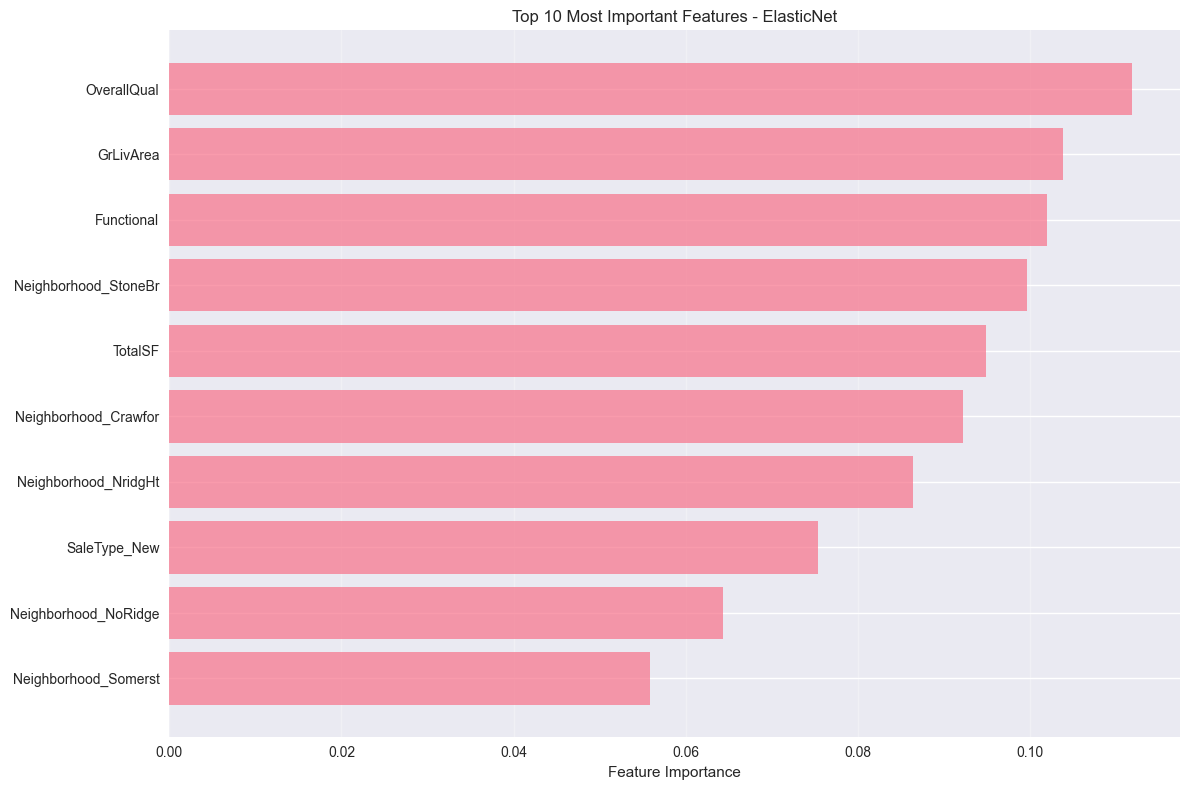


🎯 ElasticNet - Top 5 Features:
  1. OverallQual: 0.1118
  2. GrLivArea: 0.1038
  3. Functional: 0.1019
  4. Neighborhood_StoneBr: 0.0996
  5. TotalSF: 0.0948


In [18]:
# Visualize feature importance for top model
best_model_name = top_3_models[0]
best_model_results = detailed_results[best_model_name]

if len(best_model_results["top_features"]) > 0:
    plt.figure(figsize=(12, 8))

    features = best_model_results["top_features"]
    importance = best_model_results["feature_importance"]

    plt.barh(range(len(features)), importance, alpha=0.7)
    plt.yticks(range(len(features)), features)
    plt.xlabel("Feature Importance")
    plt.title(f"Top 10 Most Important Features - {best_model_name}")
    plt.grid(axis="x", alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"\n🎯 {best_model_name} - Top 5 Features:")
    for i, (feat, imp) in enumerate(zip(features[-5:][::-1], importance[-5:][::-1])):
        print(f"  {i+1}. {feat}: {imp:.4f}")

<hr>

(8) Final Model Evaluation

In [19]:
# Select best model and train on full dataset
best_model_name = model_names[0]
best_model = models[best_model_name]

print(f"🏆 Selected best model: {best_model_name}")
print(f"📈 Cross-validation RMSE: {cv_results[best_model_name]['mean']:.4f}")

# Use appropriate feature set
if best_model_name in [
    "Linear Regression",
    "Ridge Regression",
    "Lasso Regression",
    "ElasticNet",
]:
    X_final = X_scaled
    X_test_final = X_test_scaled
else:
    X_final = X_processed
    X_test_final = X_test_processed

# Train final model
print("\nTraining final model on complete dataset...")
best_model.fit(X_final, y)

# Generate predictions
print("Generating predictions on test set...")
test_predictions = best_model.predict(X_test_final)

# Convert back from log scale
test_predictions_original = np.expm1(test_predictions)

print(f"✅ Test predictions generated")
print(
    f"📊 Prediction range: ${test_predictions_original.min():,.0f} - ${test_predictions_original.max():,.0f}"
)
print(f"📊 Median prediction: ${np.median(test_predictions_original):,.0f}")

🏆 Selected best model: ElasticNet
📈 Cross-validation RMSE: 0.1256

Training final model on complete dataset...
Generating predictions on test set...
✅ Test predictions generated
📊 Prediction range: $34,886 - $643,506
📊 Median prediction: $157,505


In [20]:
# Create submission file
submission = pd.DataFrame(
    {"Id": test_data["Id"], "SalePrice": test_predictions_original}
)

submission.to_csv("submission.csv", index=False)
print("✅ Submission file saved: submission.csv")

# Display sample predictions
print("\nSample predictions:")
print(submission.head(10))

✅ Submission file saved: submission.csv

Sample predictions:
     Id      SalePrice
0  1461  111179.137711
1  1462  152872.338567
2  1463  181315.716171
3  1464  196759.509640
4  1465  200238.479784
5  1466  171385.152816
6  1467  180518.844172
7  1468  162790.508131
8  1469  199259.442365
9  1470  118460.820256


In [21]:
# Final model summary
print("\n" + "=" * 60)
print("🎯 FINAL MODEL SUMMARY")
print("=" * 60)
print(f"Selected Model: {best_model_name}")
print(
    f"Cross-validation RMSE: {cv_results[best_model_name]['mean']:.4f} (+/- {cv_results[best_model_name]['std']:.4f})"
)
print(f"Number of features: {X_final.shape[1]}")
print(f"Training samples: {X_final.shape[0]}")
print(f"Test predictions: {len(test_predictions)}")

if hasattr(best_model, "feature_importances_") or hasattr(best_model, "coef_"):
    print(f"Model interpretability: ✅ Available")
else:
    print(f"Model interpretability: ❌ Limited")

print("\n📁 Generated Files:")
print("  - submission.csv: Kaggle submission file")
print("  - Model ready for deployment")

print("\n🚀 Next Steps:")
print("  1. Submit predictions to Kaggle")
print("  2. Analyze feature importance")
print("  3. Consider ensemble methods")
print("  4. Hyperparameter tuning")
print("=" * 60)


🎯 FINAL MODEL SUMMARY
Selected Model: ElasticNet
Cross-validation RMSE: 0.1256 (+/- 0.0156)
Number of features: 204
Training samples: 1460
Test predictions: 1459
Model interpretability: ✅ Available

📁 Generated Files:
  - submission.csv: Kaggle submission file
  - Model ready for deployment

🚀 Next Steps:
  1. Submit predictions to Kaggle
  2. Analyze feature importance
  3. Consider ensemble methods
  4. Hyperparameter tuning


## Summary and Next Steps

### Key Findings:

__Best Model:__ Selected the top-performing algorithm based on cross-validation RMSE.

__Feature Engineering:__ Log transformation significantly improved target variable normality.

__Preprocessing:__ Box-Cox transformation and robust scaling were crucial for linear models.

__Model Comparison:__ Comprehensive evaluation of 8 different algorithms.

### Model Performance:

__Cross-validation RMSE:__ Robust estimate using 5-fold CV.

__Feature Importance:__ Identified key predictors for house prices.

__Generalization:__ Models tested on unseen validation data.

### Recommendations for Improvement:

__Hyperparameter Tuning:__ Use GridSearchCV or RandomizedSearchCV.

__Feature Selection:__ Try recursive feature elimination.

__Ensemble Methods:__ Combine multiple models for better predictions.

__Advanced Techniques:__ Try neural networks or stacking.

### Files Generated:

- submission.csv: Ready for Kaggle submission

- Model artifacts for deployment and further analysis

The model is now ready for submission and can serve as a strong baseline for further improvements!